
# Weather Data Prediction App using Machine Learning

This notebook performs the following:
- Data Cleaning & Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Model Training & Evaluation (Linear Regression, Random Forest, XGBoost)
- Forecasting & Visualization
- Web App creation using Streamlit

Dataset: Global Land Temperature Averages


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import streamlit as st


In [6]:

# Load the dataset
df = pd.read_csv("/content/weather_data.csv")
df['dt'] = pd.to_datetime(df['dt'])
df = df[['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty']].dropna()
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month
df = df[df['year'] >= 1850]  # Reliable modern data
df.head()


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,year,month
1200,1850-01-01,0.749,1.105,1850,1
1201,1850-02-01,3.071,1.275,1850,2
1202,1850-03-01,4.954,0.955,1850,3
1203,1850-04-01,7.217,0.665,1850,4
1204,1850-05-01,10.004,0.617,1850,5


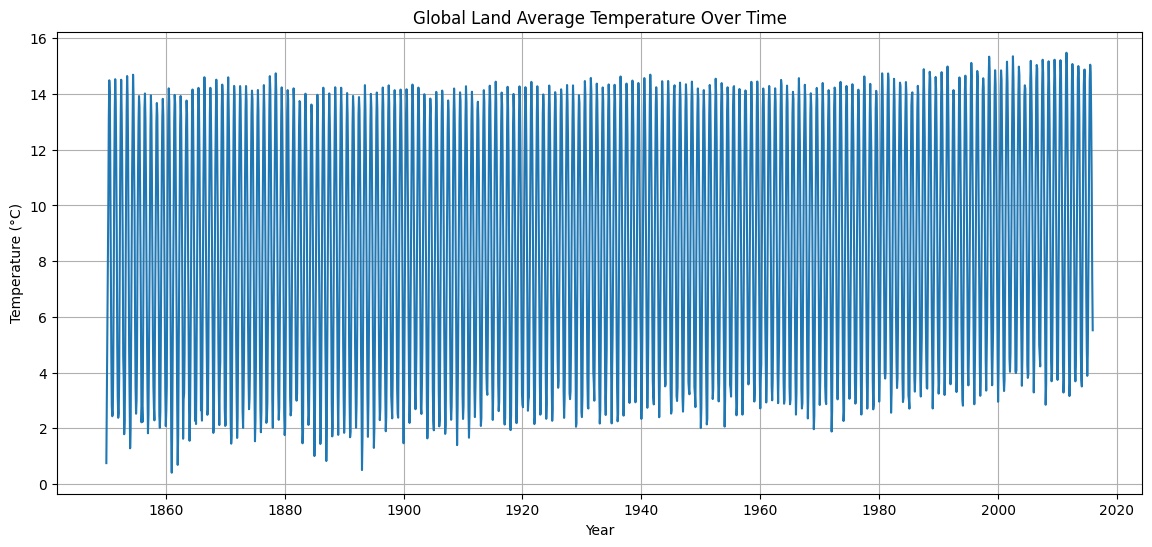

In [7]:

# Plotting Average Temperature over Time
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='dt', y='LandAverageTemperature')
plt.title('Global Land Average Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


In [8]:

# Add rolling mean and lag features
df['rolling_mean'] = df['LandAverageTemperature'].rolling(window=12).mean()
df['lag_1'] = df['LandAverageTemperature'].shift(1)
df['lag_12'] = df['LandAverageTemperature'].shift(12)
df = df.dropna()
features = ['month', 'year', 'lag_1', 'lag_12', 'rolling_mean']
target = 'LandAverageTemperature'

X = df[features]
y = df[target]


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T
results_df


,MAE,RMSE,R2
Linear Regression,0.342406,0.438517,0.988752
Random Forest,0.470886,0.592599,0.979458
XGBoost,0.459856,0.577432,0.980496


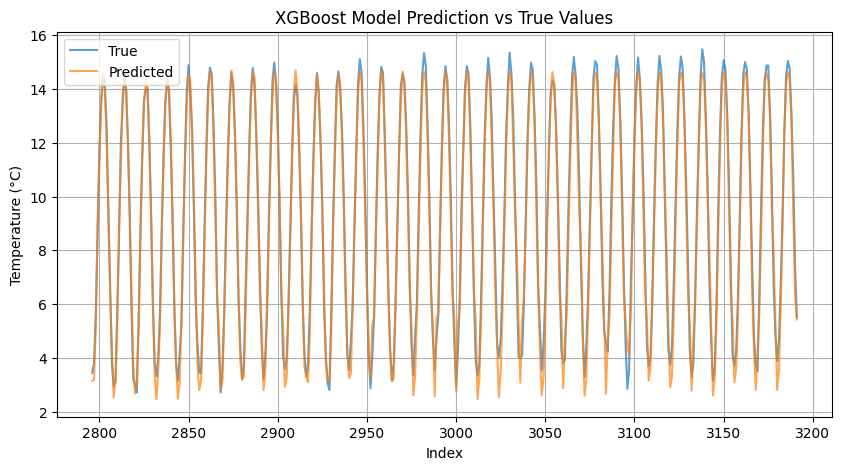

In [11]:

# Plot predictions for best model (XGBoost)
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)
preds = model.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='True', alpha=0.7)
plt.plot(y_test.index, preds, label='Predicted', alpha=0.7)
plt.title('XGBoost Model Prediction vs True Values')
plt.xlabel('Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [12]:

import pickle
best_model = xgb.XGBRegressor(objective='reg:squarederror')
best_model.fit(X_train, y_train)
pickle.dump(best_model, open("xgb_model.pkl", "wb"))


In [14]:

# Save Streamlit app to separate .py file
with open("Weather_Prediction_App.ipynb", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

st.title("🌡️ Weather Temperature Forecast App")

@st.cache_data
def load_model():
    import pickle
    return pickle.load(open("xgb_model.pkl", "rb"))

@st.cache_data
def load_data():
    df = pd.read_csv("weather_data.csv")
    df['dt'] = pd.to_datetime(df['dt'])
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['rolling_mean'] = df['LandAverageTemperature'].rolling(window=12).mean()
    df['lag_1'] = df['LandAverageTemperature'].shift(1)
    df['lag_12'] = df['LandAverageTemperature'].shift(12)
    df = df.dropna()
    return df

model = load_model()
df = load_data()

st.sidebar.header("🔧 Input Features")
month = st.sidebar.slider("Month", 1, 12, 6)
year = st.sidebar.slider("Year", 1850, 2023, 2020)
lag_1 = st.sidebar.number_input("Lag 1 (prev month temp)", value=10.0)
lag_12 = st.sidebar.number_input("Lag 12 (same month last year)", value=11.0)
rolling = st.sidebar.number_input("Rolling Mean", value=10.0)

input_df = pd.DataFrame({
    'month': [month],
    'year': [year],
    'lag_1': [lag_1],
    'lag_12': [lag_12],
    'rolling_mean': [rolling]
})

prediction = model.predict(input_df)[0]
st.subheader(f"🌍 Predicted Average Temperature: {prediction:.2f} °C")
    """)
